<a href="https://colab.research.google.com/github/MaryamOsamaX/Arabic_Poetry_Metric_Classification/blob/master/Arabic_Poetry_Metric_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
#!wget  -P /content/drive/MyDrive/data/ /content/sample_data/anscombe.json
!gsutil -q -m cp /content/sample_data/anscombe.json /content/drive/MyDrive/data/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt # ploting library
import string
import re
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, Embedding, Dense, Input, Dropout, Bidirectional, BatchNormalization, Flatten, Reshape
from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer, text_to_word_sequence


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/train.csv')
df.head()

,labels,data
0,8,أَنا الفقير وباللَه العظيم غني # لئن فقدتك في ...
1,10,وَلوعاً بِيُمنَى نَمْنَمَتْها حَدِيقَةٌ # نَزْ...
2,11,فيا منْ لم أزلْ أحظى لديه # بفضلٍ جامعٍ بابَ ا...
3,9,وَسَلامٌ عَلَى ضَرِيحِكَ مَا أَهْ # دَتْ شَذَا...
4,8,أمِنْتُ فقري لما قُلتُ عن ثِقَةٍ # أنْ لا جواد...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  20000 non-null  int64 
 1   data    20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
df.nunique()

labels       14
data      19989
dtype: int64

In [ ]:
df.duplicated().sum()

11

In [ ]:
df[df.duplicated()]

,labels,data
7466,7,قَرّت الحالُ بِكُم في نِعَم # أنْطَقَتنِي بِال...
9104,11,وَمَا أَحَدٌ أَحَقَّ بأَخْذِ مَالٍ # مِنَ الأت...
10164,11,إذَا أُمَناؤُنَا قَبِلُوا الهَدَايا # وَصَارُو...
10417,5,مَنْ جَرَى فِي غَيْرِ حَلْبَتِهِ # كَانَ مَوْق...
11456,10,ومَنْ رامَ يحيى كَعْبَةً لِطَوافِه # غدا لا يُ...
11548,7,وَاقْتَدَى الرُّهْبَانُ فِي نُدْبَتِهِ # بِلَب...
18552,10,تَقَبّل آثارَ الخَليفَة مُسلِفا # بِها قُرباً ...
19334,10,وَقَد كُنتُ أَشكو عَتبَها وَعِتابَها # فَقَد ف...
19617,0,سائِل بَني الأَشعَرِ إِن جِئتَهُم # ما كانَ أَ...
19862,7,صَرَخَ النّاقوسُ يَبكِي يَوْمَهُ # لِتَنَاهِي ...


In [ ]:
for i in df[df.duplicated()]['data']:
    print(i)

قَرّت الحالُ بِكُم في نِعَم # أنْطَقَتنِي بِالقَوافِي الشردِ
وَمَا أَحَدٌ أَحَقَّ بأَخْذِ مَالٍ # مِنَ الأتْرَاكِ وَالمُتَجَنِّدِينا
إذَا أُمَناؤُنَا قَبِلُوا الهَدَايا # وَصَارُوا يَتْجَرُونَ وَيَزْرَعُونا
مَنْ جَرَى فِي غَيْرِ حَلْبَتِهِ # كَانَ مَوْقُوفَاً عَلَى الظِّنَنِ
ومَنْ رامَ يحيى كَعْبَةً لِطَوافِه # غدا لا يُهابُ الهَضْم في ذَرْوَة الهَضْبِ
وَاقْتَدَى الرُّهْبَانُ فِي نُدْبَتِهِ # بِلَبيد في أَخيهِ أرْبَدِ
تَقَبّل آثارَ الخَليفَة مُسلِفا # بِها قُرباً تحْظى من اللّهِ بالقُرْبِ
وَقَد كُنتُ أَشكو عَتبَها وَعِتابَها # فَقَد فَجَعَتني بِالعِتابِ وَبِالعَتبِ
سائِل بَني الأَشعَرِ إِن جِئتَهُم # ما كانَ أَنباءُ أَبي واسِعِ
صَرَخَ النّاقوسُ يَبكِي يَوْمَهُ # لِتَنَاهِي عُدَدٍ أوْ عَدَدِ
غَرّه البُعدُ وعن قرْبٍ يَرى # جِزْيةَ الكُفْرِ تُؤَدَّى عَن يَدِ


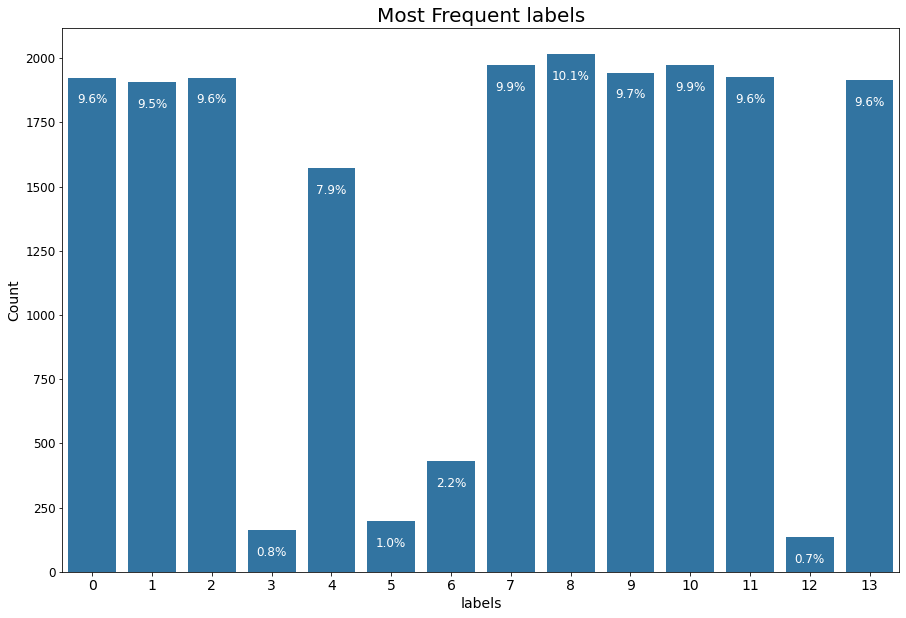

In [ ]:
plt.figure(figsize=(15,10))
counts=df['labels'].value_counts()

base_color = sns.color_palette()[0]
sns.countplot(data=df, x='labels', color=base_color,linewidth=100);
plt.ylabel('Count',fontsize = 14)
plt.xlabel('labels',fontsize = 14)
plt.title('Most Frequent labels',fontsize = 20)
plt.yticks(size=12); 
totale = len(df)
locs, labels = plt.xticks(size=14); 
for loc, label in zip(locs, labels):
    count = counts[int(label.get_text())]
    pct_string = '{:0.1f}%'.format(100*count/totale)
    plt.text(loc, count-100, pct_string, ha = 'center', color = 'white',fontsize = 12)

In [ ]:
def remove_punc(s):
    punctuations = '''`÷×؛ʿˇ<>()*&^%]‚[،/:ღ"┈؟.,'{}~¦+ ، 》《|﴾»«﴿!”…“–❒ـ۞✦✩☜ ̷ ﮼☻󾌴❥*،“¸.•°``°•.`•.¸.•♫♡—''' + string.punctuation
    punctuations = ''.join(set(punctuations)-{'ـ','#'})
    for c in punctuations:
        s=s.replace(c," ")
    return s


def clean_text(text):
    arabic_diacritics = re.compile(""" ّ| َ| ً| ُ| ٌ| ِ| ٍ| ْ| ۖ| ۠| ۘ| ۙ| ۚ| ۛ| ۜ| ۗ| ۡ| ۟| ۤ|ۥ| ۧ""", re.VERBOSE)
    #text = extract_arabic(text)
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    #text = text.translate(str.maketrans(' ', '  ', punctuations))
    text = remove_punc(text)
    text = re.compile(r'[a-zA-Z\u0590-\u05FF\u200f\u200eÀ-ÿ-. ǻħḿєığīā]').sub(' ', text)
    text = weridPatterns.sub(' ', text)
    #text = re.sub(arabic_diacritics, '', text)
    text = re.sub('\d+', ' ', text)
    text = re.sub('ﷺ', 'صلى الله عليه وسلم', text)
    text = re.sub('_', ' ', text)
    text = re.sub('ـ', '', text)                           
    text = re.sub('،', ' ', text)
    text = re.sub('URL', '', text)
    text = re.sub('USER', '', text)
    text = re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', text)
    text = re.sub('\s+', ' ', text)
    return text

In [ ]:
df['clean_data']=df['data'].apply(clean_text)

In [ ]:
df['clean_data']

0        أَنا الفقير وباللَه العظيم غني # لئن فقدتك في ...
1        وَلوعاً بِيُمنَى نَمْنَمَتْها حَدِيقَةٌ # نَزْ...
2        فيا منْ لم أزلْ أحظى لديه # بفضلٍ جامعٍ بابَ ا...
3        وَسَلامٌ عَلَى ضَرِيحِكَ مَا أَهْ # دَتْ شَذَا...
4        أمِنْتُ فقري لما قُلتُ عن ثِقَةٍ # أنْ لا جواد...
                               ...                        
19995    ولا برِحَ الزمانُ به ربيعاً # يطرّزُ زَهرُهُ ح...
19996    يَوْمَ لاَ يَجْزِي وَالِدٌ عَنْ وَلِيدٍ # لاَ ...
19997    فَليُرِنا الوَردُ إِن شَكا يَدَهُ # أَحسَنَ مِ...
19998    وَالمرَءُ كَالبائِعُ في سوقِهِ # يَأخُذُ ما يُ...
19999    وتوالَتْ بُشْرَى الهواتفِ أن قدْ # وُلِدَ المص...
Name: clean_data, Length: 20000, dtype: object

In [ ]:
df.head()

,labels,data,clean_data
0,8,أَنا الفقير وباللَه العظيم غني # لئن فقدتك في ...,أَنا الفقير وباللَه العظيم غني # لئن فقدتك في ...
1,10,وَلوعاً بِيُمنَى نَمْنَمَتْها حَدِيقَةٌ # نَزْ...,وَلوعاً بِيُمنَى نَمْنَمَتْها حَدِيقَةٌ # نَزْ...
2,11,فيا منْ لم أزلْ أحظى لديه # بفضلٍ جامعٍ بابَ ا...,فيا منْ لم أزلْ أحظى لديه # بفضلٍ جامعٍ بابَ ا...
3,9,وَسَلامٌ عَلَى ضَرِيحِكَ مَا أَهْ # دَتْ شَذَا...,وَسَلامٌ عَلَى ضَرِيحِكَ مَا أَهْ # دَتْ شَذَا...
4,8,أمِنْتُ فقري لما قُلتُ عن ثِقَةٍ # أنْ لا جواد...,أمِنْتُ فقري لما قُلتُ عن ثِقَةٍ # أنْ لا جواد...


In [ ]:
vocab = sorted(set(' '.join(df['clean_data'])))

In [ ]:
vocab

[' ',
 '#',
 'ء',
 'آ',
 'أ',
 'ؤ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي',
 'ً',
 'ٌ',
 'ٍ',
 'َ',
 'ُ',
 'ِ',
 'ّ',
 'ْ']

In [ ]:
char2idx = {u:i+1 for i, u in enumerate(vocab)}

def to_sequences(X):
    X = [[char2idx[char] for char in line] for line in X]
    X = pad_sequences(X, padding='post', value=0, maxlen = 100)
    return X


In [ ]:
X_train = to_sequences(df['clean_data'])
y_train = df['labels']

In [ ]:
X_train

array([[ 5, 42, 34, ...,  0,  0,  0],
       [36, 42, 32, ...,  0,  0,  0],
       [29, 38,  9, ...,  0,  0,  0],
       ...,
       [29, 42, 32, ...,  0,  0,  0],
       [36, 42,  9, ...,  0,  0,  0],
       [36, 12, 36, ...,  0,  0,  0]], dtype=int32)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from collections import Counter
Counter(y_over)

Counter({0: 2016,
         1: 2016,
         2: 2016,
         3: 2016,
         4: 2016,
         5: 2016,
         6: 2016,
         7: 2016,
         8: 2016,
         9: 2016,
         10: 2016,
         11: 2016,
         12: 2016,
         13: 2016})

In [ ]:
model = Sequential()
model.add(Input((100,)))
model.add(Embedding(len(char2idx)+1, 256))
model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
model.add(Bidirectional(GRU(units = 256)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(14, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 256)          12032     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 512)          789504    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 512)          1182720   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 14)                1806      
Total params: 3,234,446
Trainable params: 3,234,446
Non-trainable params: 0
____________________________________________

In [ ]:
model(tf.zeros((10, 100))).shape

TensorShape([10, 14])

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_delta=0.0001, min_lr=0.0001)]
callbacks += [tf.keras.callbacks.ModelCheckpoint('full_verse.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/data/saved_model/my_model')

# Check its architecture
#new_model.summary()

In [ ]:
model.fit(X_train, y_train, epochs = 15, batch_size= 128, shuffle = True, callbacks=callbacks)

Epoch 1/15
157/157 [==============================] - 25s 114ms/step - loss: 0.0736 - accuracy: 0.9765


Epoch 2/15
157/157 [==============================] - 18s 116ms/step - loss: 0.0515 - accuracy: 0.9830


Epoch 3/15
157/157 [==============================] - 19s 118ms/step - loss: 0.0763 - accuracy: 0.9761


Epoch 4/15
157/157 [==============================] - 19s 119ms/step - loss: 0.0471 - accuracy: 0.9851


Epoch 5/15
157/157 [==============================] - 18s 118ms/step - loss: 0.0530 - accuracy: 0.9844


Epoch 6/15
157/157 [==============================] - 18s 117ms/step - loss: 0.0426 - accuracy: 0.9858


Epoch 7/15
157/157 [==============================] - 18s 117ms/step - loss: 0.0928 - accuracy: 0.9712


Epoch 8/15
157/157 [==============================] - 18s 118ms/step - loss: 0.0359 - accuracy: 0.9883


Epoch 9/15
157/157 [==============================] - 19s 118ms/step - loss: 0.0475 - accuracy: 0.9869


Epoch 10/15
157/157 [==============================] - 19s 119ms/step - loss: 0.1050 - accuracy: 0.9678


Epoch 11/15
157/157 [==============================] - 19s 119ms/step - loss: 0.0569 - accuracy: 0.9815


Epoch 12/15
157/157 [==============================] - 19s 119ms/step - loss: 0.0330 - accuracy: 0.9894


Epoch 13/15
157/157 [==============================] - 18s 118ms/step - loss: 0.0355 - accuracy: 0.9898


Epoch 14/15
157/157 [==============================] - 18s 118ms/step - loss: 0.0591 - accuracy: 0.9824


Epoch 15/15
157/157 [==============================] - 18s 118ms/step - loss: 0.0316 - accuracy: 0.9898


In [ ]:
def classify(sentence):
#   sentence = process_review(sentence)
    sentence = clean_text(sentence)
    sequence = [char2idx[char] for char in sentence]
    sequence = pad_sequences([sequence], maxlen = X_train.shape[1], padding='post', value=0)

    pred = model.predict(sequence)[0]
    #print(np.argmax(pred, 0).astype('int'), np.max(pred))
    return np.argmax(pred, 0).astype('int')


In [ ]:
x = df.iloc[0]['data']
print(df.iloc[0])
classify(df.iloc[0]['data'])

labels                                                        8
data          أَنا الفقير وباللَه العظيم غني # لئن فقدتك في ...
clean_data    أَنا الفقير وباللَه العظيم غني # لئن فقدتك في ...
Name: 0, dtype: object


8

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/data/test.csv')
test_df.head()

,id,data
0,0,بلوعة قذف للنية القذف # أخي سنادي معيني قوتي جدتي
1,1,وعَلِيقِي عليه أَرْخَصُ مِنْ ما # لِ المَوارِي...
2,2,تنزه في الثغر مبني في # محل العذيب وفي بارق
3,3,قديرٌ ذو قُدورٍ راسياتٍ # تُقابلُها جِفانٌ كال...
4,4,وبانبي الهدى وافتك من بعد # مديحة من كثير العي...


In [ ]:
test_df['labels'] = test_df['data'].apply(classify)

In [ ]:
test_df.head()

,id,data,labels
0,0,بلوعة قذف للنية القذف # أخي سنادي معيني قوتي جدتي,8
1,1,وعَلِيقِي عليه أَرْخَصُ مِنْ ما # لِ المَوارِي...,9
2,2,تنزه في الثغر مبني في # محل العذيب وفي بارق,0
3,3,قديرٌ ذو قُدورٍ راسياتٍ # تُقابلُها جِفانٌ كال...,11
4,4,وبانبي الهدى وافتك من بعد # مديحة من كثير العي...,8


In [ ]:
sample_submission = test_df.drop(columns=['data'])
sample_submission.to_csv("/content/drive/MyDrive/data/multi_submission.csv",index=False, encoding='utf-8-sig')

In [ ]:
#!mkdir -p saved_model
model.save('/content/drive/MyDrive/data/saved_model/model_without_dropout')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/saved_model/model_without_dropout/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/saved_model/model_without_dropout/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/data/saved_model/my_model')

# Check its architecture
new_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 256)          12032     
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 512)          789504    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          1182720   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1